In [11]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

from scipy.optimize import curve_fit


from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAnnulus
from photutils.aperture import aperture_photometry

from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, hstack, vstack
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy.table import Table
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

In [2]:
I_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_I_Farcsec_fcube_cor.fits'))[0]
I_cube = I_hdu.data[0]
Q_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_Q_Farcsec_fcube_cor.fits'))[0]
Q_cube = Q_hdu.data[0]
U_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_U_Farcsec_fcube_cor.fits'))[0]
U_cube = U_hdu.data[0]
V_hdu = fits.open(get_pkg_data_filename(r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85/Abell_85_aFix_pol_V_Farcsec_fcube_cor.fits'))[0]
V_cube = V_hdu.data[0]

I_freqmean = np.nanmean(I_cube, axis=0)
Q_freqmean = np.nanmean(Q_cube, axis=0)
U_freqmean = np.nanmean(U_cube, axis=0)
V_freqmean = np.nanmean(V_cube, axis=0)


I_wcs = WCS(I_hdu.header)
Q_wcs = WCS(Q_hdu.header)
U_wcs = WCS(U_hdu.header)
V_wcs = WCS(V_hdu.header)

In [3]:
linpol_intens_cube = np.sqrt(Q_cube**2+U_cube**2)
linpol_intens_freqmean = np.nanmean(linpol_intens_cube, axis=0)

Linpol_hdu = fits.PrimaryHDU(linpol_intens_cube)
Linpol_hdu.writeto('Abell_85_Linpol_Farcsec_fcube_cor.fits', overwrite=True)

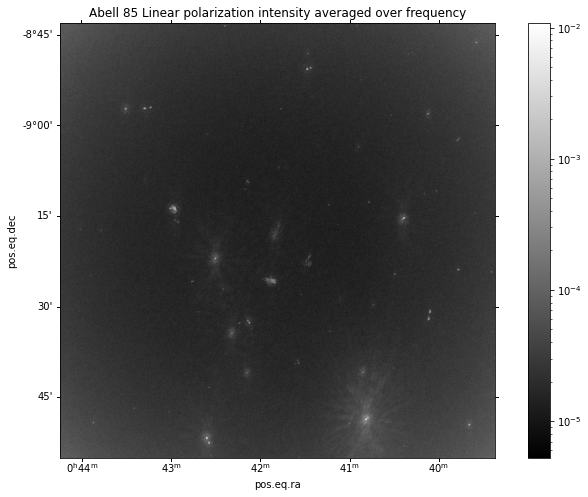

In [4]:
plt.figure(figsize=(12,8))
plt.subplot(projection=I_wcs, slices=('x', 'y', 0, 0))
plt.title('Abell 85 Linear polarization intensity averaged over frequency')
plt.imshow(linpol_intens_freqmean.clip(min=0.0000001), cmap='gray', norm=colors.LogNorm())
plt.colorbar()
plt.savefig('ACO85_Linpol_Freqmean.pdf', dpi=500)

In [5]:
backgr_mean, backgr_median, backgr_std = sigma_clipped_stats(linpol_intens_freqmean, sigma=3.0)
print((backgr_mean, backgr_median, backgr_std))

(2.2228118e-05, 2.056794e-05, 7.4738346e-06)


In [6]:
daofind = DAOStarFinder(fwhm=3.0, threshold=np.sqrt(12)*3*backgr_std)
sources = daofind(linpol_intens_freqmean - backgr_median)
for col in sources.colnames:
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)

 id xcentroid ycentroid sharpness  ... sky      peak        flux       mag     
--- --------- --------- ---------- ... --- ------------- --------- ------------
  1 1240.3743 125.05221 0.40063999 ...   0  0.0031750763 12.902322   -2.7766697
  2 1219.7997  167.3948 0.39890794 ...   0  0.0059659723 19.834065   -3.2435293
  3 3402.9638  276.6438 0.39958119 ...   0  0.0025882686 9.3137564   -2.4228122
  4  276.9332 292.87753 0.39891927 ...   0 0.00044727101 1.6578485  -0.54886213
  5 2536.2357 303.70036 0.40582735 ...   0  0.0004094062 1.0213854 -0.022974133
  6 2550.9457 307.30776 0.39009826 ...   0 0.00038503329 1.0856967 -0.089271269
  7 2540.8233 309.27523 0.40376552 ...   0  0.0005052943 1.3174664  -0.29934885
  8 2530.1416 311.28941 0.40689776 ...   0 0.00039638649 1.3044421  -0.28856199
  9 2544.4722   321.465 0.39895931 ...   0   0.010829131 38.245097   -3.9564394
 10 2532.3276  323.0863 0.40942622 ...   0 0.00038384809 1.3148333  -0.29717675
...       ...       ...        ... ... .

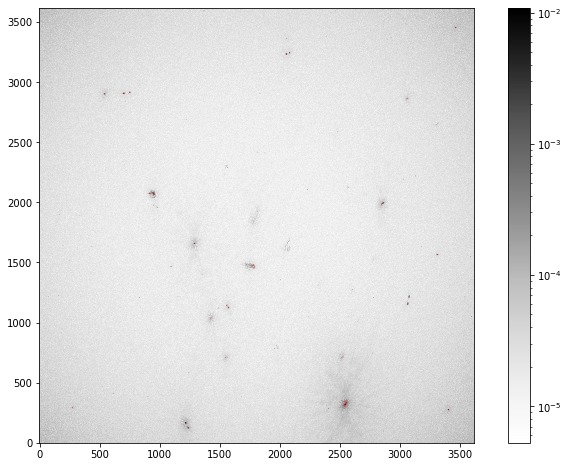

In [23]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=7.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(12,8))
plt.imshow(linpol_intens_freqmean.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.colorbar()
apertures.plot(color='red', lw=0.1)
plt.savefig('ACO85_Linpol_FreqmeanSourcedetect.pdf', dpi=500)

In [122]:
annulus_apertures = CircularAnnulus(positions, r_in=8., r_out=13.)
apers = [apertures, annulus_apertures]

def photometry(data_local, apers_local):
    phot_table = aperture_photometry(data_local, apers_local)
    bkg_mean = phot_table['aperture_sum_1'] / apers_local[1].area
    bkg_sum = bkg_mean * apers_local[0].area
    final_sum = phot_table['aperture_sum_0'] - bkg_sum
    phot_table['residual_aperture_sum'] = final_sum
    return(phot_table)

photometry(linpol_intens_freqmean, apers)
print(phot_table['residual_aperture_sum'])

residual_aperture_sum
---------------------
  0.09685237647763098
   0.2545311008964852
  0.09621135402664918
 0.008778655975428682
-0.030058501416035548
-0.057773386158651754
 -0.19571146339427886
   -0.049808956032905
  0.42115671890548845
  -0.2172978214833865
                  ...
 0.016467494222443032
-0.023084921593364855
-0.033647488364603434
 0.019913403434786786
 0.048751536042390596
 0.044491798747786734
 0.022496583141356205
  0.02452166636343005
  0.06775258462058385
  0.02413406185265509
  0.03076232237805357
Length = 42 rows


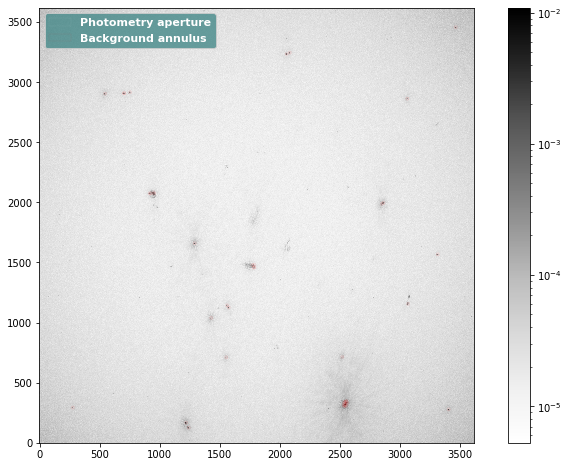

In [123]:
from astropy.visualization import simple_norm

plt.figure(figsize=(12,8))
plt.imshow(linpol_intens_freqmean.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.colorbar()

ap_patches = apertures.plot(color='white', lw=0.05, label='Photometry aperture')
ann_patches = annulus_apertures.plot(color='red', lw=0.05, label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(facecolor='#458989', labelcolor='white', handles=handles, prop={'weight': 'bold', 'size': 11})
plt.savefig('ACO85_Linpol_Photometry.pdf', dpi=300)

In [124]:
I_phot_table = np.zeros((12, len(sources)))
Q_phot_table = np.zeros((12, len(sources)))
U_phot_table = np.zeros((12, len(sources)))
V_phot_table = np.zeros((12, len(sources)))

for n in range(12):
    I_slice_phot = photometry(I_cube[n], apers)
    Q_slice_phot = photometry(Q_cube[n], apers)
    U_slice_phot = photometry(U_cube[n], apers)
    V_slice_phot = photometry(V_cube[n], apers)
    for i in range(len(sources)):
        I_phot_table[n, i] = I_slice_phot[i]['residual_aperture_sum']
        Q_phot_table[n, i] = Q_slice_phot[i]['residual_aperture_sum']
        U_phot_table[n, i] = U_slice_phot[i]['residual_aperture_sum']
        V_phot_table[n, i] = V_slice_phot[i]['residual_aperture_sum']

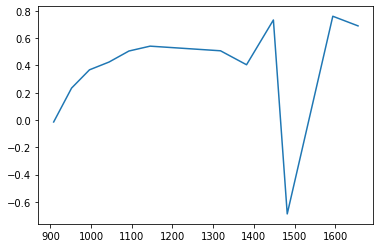

[0.44119187 0.45326133 0.4426352  0.4390527  0.43292141 0.43798518
 0.39653216 0.40507396 0.41260246 0.45115124 0.4507028  0.52499496]


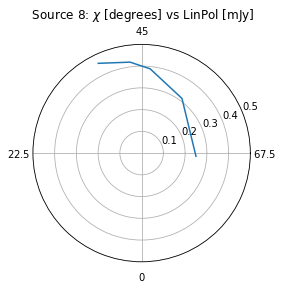

In [151]:
Pol_Angles = 0.5*np.arctan(U_phot_table/Q_phot_table)
Freqs = np.array([908, 952, 996, 1044, 1093, 1145, 1318, 1382, 1448, 1482, 1594, 1656])# MHz
plt.plot(Freqs, Pol_Angles[:,8])
plt.show()
print(I_phot_table[:,3])
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(4*Pol_Angles[:5,8], np.sqrt(Q_phot_table[:5,8]**2+U_phot_table[:5,8]**2))
ax.set_rmax(0.5)
ax.set_xticks(np.pi/180 * np.linspace(270,  0, 4))
ax.set_xticklabels([
    r'$0$',
    r'$22.5$',
    r'$45$',
    r'$67.5$'],
    fontsize=10)
ax.grid(True)

ax.set_title(r" Source 8: $\chi$ [degrees] vs LinPol [mJy]")
plt.show()